# Introduction to PS

In this tutorial, we present how to set up a simple projective simulation (PS) agent to learn to play the invader game. To do so, we will first set up the environment and create a basis instantiation of PS agent with a two-layer ECM. We will then train the agent during episodes of deliberation and updates and plot the final learning curve.

## Install the PS package

Start by making sure that you have access to the package: clone the repository using `git clone https://github.com/qic-ibk/projective_simulation.git` from your terminal, in your project's folder. Install the package with the command `pip install -e .`. To remove dependencies on user-specific metadata, run the command `nbdev_install_hooks`. 

## Set up the environment

The invader opposes two agents. The invader attempts to enter a city and shows a sign to the defender to indicate his intention to move right or left. In order to defend his territory, the defender learns to move in the matching direction in order to block the defender. The invader can either declare his true intention or he can lie and show the opposite direction instead. The defender must adapt his strategy accordingly.

Let us now set the environment up by creating the invader game environment:

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

import projective_simulation.envs.core as environments


env = environments.Invader_Game_Env()

## Create the agent

For this task, we PS-agent that has two actions ("go right" and "go left") and an ECM organized in two layers suffices. Deliberation will operate by transitioning directly from percepts to actions in a random walk.

At the same time, we set the hyperparameters of the agent. The damping parameter $\gamma$ represents forgetting: when large, the agent forgets what it has reinforced in the previous episodes. The edge weight, the h-values, are updated as follows for an edge linking clip $i$ to clip $j$ after receiving a reward $R$ from the environment:
\begin{equation}
h_{ij}^{(t)} = (1-\gamma) \cdot h_{ij}^{(t-1)} + \gamma \cdot h_{ij}^{(0)} + R\cdot g_{ij}^{(t)}
\end{equation}

 The glow parameter $\eta$ decides how quickly the agent forgets it sampled a specific edge to deliberate: if one, the agent can remember and reward exactly one step, whereas if it takes a smaller value, edges that were sampled in the past will be reinforced proportionally to how far in the past they were used:
\begin{equation}
g_{ij}^{(t)} = \begin{cases} 
 1 &\text{ if edge $i-j$ was sampled last} \\
 (1-\eta) g_{ij}^{(t-1)} &\text{otherwise}
 \end{cases}
 \end{equation}

Since the invader game environment does not require any memory beyond one step, we set both parameters to 0 for this task.

In [ ]:
import projective_simulation.agents.core as agents

# Create a basic two-layer agent, with two actions
agent = agents.Basic_2Layer_Agent(num_actions=2,
                                 glow=1,
                                 damp=0,
                                 policy = 'softmax',
                                 policy_parameters=1)

## Train the agent

Integrate agent and environment to create a percept-action loop during which the agent deliberates and updates its memory.

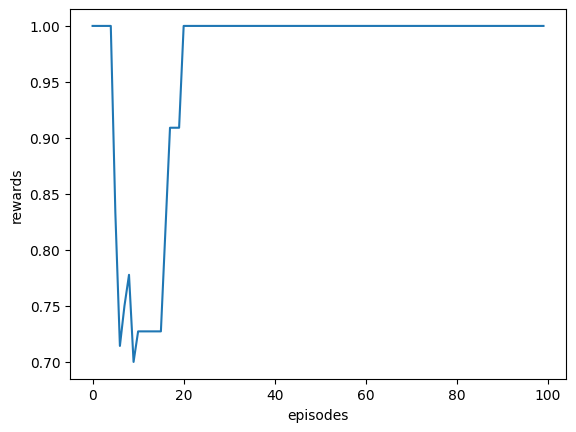

In [ ]:
# Store the reward history of the agent

reward_history = []
N_episodes = 100
# Initialize the sign of the invader
for episode in range(N_episodes):
    percept = env.get_observation()
    action = agent.deliberate(percept)
    reward = env.get_reward(action, liar=False)
    agent.update(reward)
    reward_history.append(reward)
    env.transition(action)


# Plot the learning curve
plt.plot(list(range(len(reward_history))), 
              [np.mean([reward_history[step] for step in range(i-10,i+1) if step >= 0]) for i in range(N_episodes)])
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.show()


We can check the attributes of the agent:

In [ ]:
# Check the percepts the agent has encountered
print("percepts: ", agent.ECM.percepts)

# Check the h-values of the agent
print("ECM:", agent.ECM.hmatrix)

percepts:  {'left': 0, 'right': 1}
ECM: [[  1. 527.]
 [474.   1.]]


We can now train 10 agents to have an average learning curve.

[<matplotlib.lines.Line2D>]

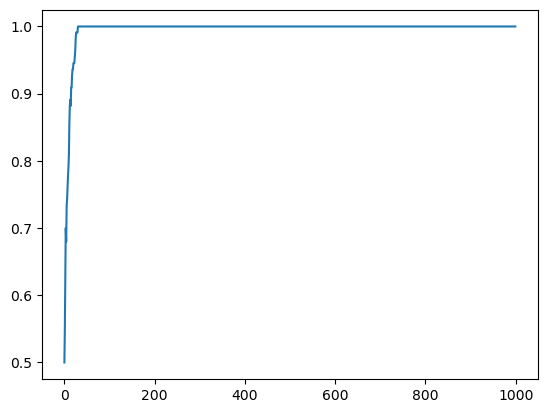

In [ ]:
N_agents = 10
reward_history = []

for i in range(N_agents):
    reward_history.append([])
    env = environments.Invader_Game_Env()
    agent = agents.Basic_2Layer_Agent(num_actions=2,
                                     glow=1,
                                     damp=0,
                                     policy = 'softmax',
                                     policy_parameters=1)
    for episode in range(N_episodes):
        percept = env.get_observation()
        action = agent.deliberate(percept)
        reward = env.get_reward(action, liar=False)
        agent.update(reward)
        reward_history[i].append(reward)
        env.transition(action)

# Plot the average learning curve
mean_rewards = np.mean(np.array(reward_history), axis=0)
plt.plot(list(range(len(reward_history[0]))), 
              [np.mean([mean_rewards[step] for step in range(i-10,i+1) if step >= 0]) for i in range(N_episodes)])


## Effect of the forgetting parameter $\gamma$

In order to understand the importance of the different hyperparameters, we train the agents in different scenarios. We start by exploring the role of the forgetting parameter. For this, we switch the strategy of the invader from non-liar to liar in the middle of the training, and explore the impact this switch on the learning curve for agents with different learning rates.

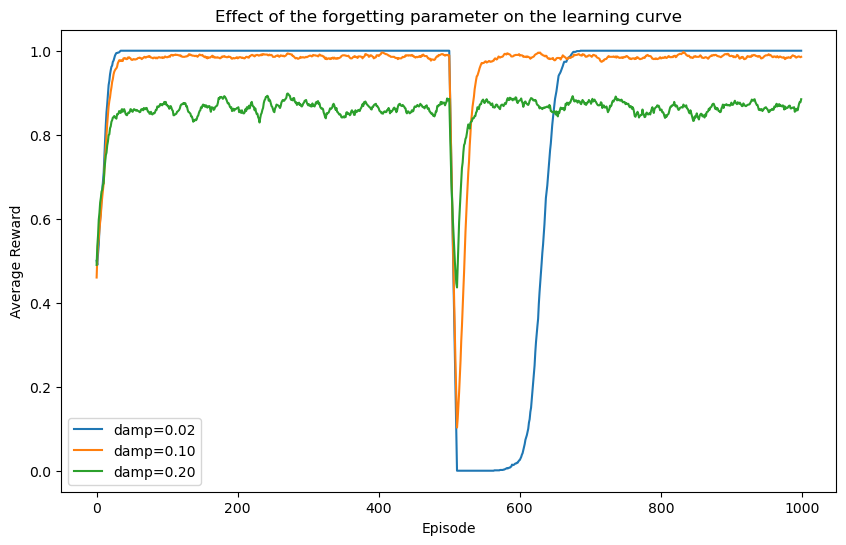

In [ ]:
N_agents = 100
reward_history = []
damp_params = [1/50, 1/10, 1/5]

for d in range(len(damp_params)):
    reward_history.append([])
    for i in range(N_agents):
        reward_history[d].append([])
        env = environments.Invader_Game_Env()
        agent = agents.Basic_2Layer_Agent(num_actions=2,
                                        glow=1,
                                        damp=damp_params[d],
                                        policy = 'softmax',
                                        policy_parameters=1)
        for episode in range(N_episodes):
            percept = env.get_observation()
            action = agent.deliberate(percept)
            reward = env.get_reward(action, liar=episode > N_episodes // 2)
            agent.update(reward)
            reward_history[d][i].append(reward)
            env.transition(action)

# Plot the average learning curve
mean_rewards = [np.mean(np.array(reward_history[d]), axis=0) for d in range(len(damp_params))]
fig, ax = plt.subplots(figsize=(10, 6))
for d in range(len(damp_params)):
    ax.plot(list(range(N_episodes)), 
              [np.mean([mean_rewards[d][step] for step in range(i-10,i+1) if step >= 0]) for i in range(N_episodes)],
              label=f'damp={damp_params[d]:.2f}')
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.set_title('Effect of the forgetting parameter on the learning curve')
plt.show()

## Test the effect of the glow parameter

In order to understand the role of the glow damping parameter, we need to set up an environment that requires the agent to remember more than a single percept to properly contextualize its policy. Therefore, we use the Grid World environment that consists of a 2D grid with a number of obstacles. The goal of the agent is to reach a target at a precise location.

Since rewards in this environment are sparse (only a single cell leads to a reward), reinforcement must be applied to the whole trajectory for the agent to learn to navigate the whole grid towards the target. Therefore, we now make use of glow and tune its damping parameter to values smaller than 1.

In [ ]:
# Plot the environment
def plot_Grid_World(obs_loc, reward_loc, initial_loc):
    # Plot the grid with obstacles, reward, initial location, and learnt policy arrows
    # Get grid dimensions
    grid_shape = env.dimensions
    fig, ax = plt.subplots(figsize=(9,6))
    ax.set_xlim(0, grid_shape[1])
    ax.set_ylim(0, grid_shape[0])
    ax.set_xticks(np.arange(grid_shape[1]))
    ax.set_yticks(np.arange(grid_shape[0]))
    
    # Draw obstacles
    for loc in obs_loc:
        ax.add_patch(plt.Rectangle((loc[1], loc[0]), 1, 1, color='black', alpha=0.5))
    
    # Draw reward location
    ax.add_patch(plt.Rectangle((reward_loc[1], reward_loc[0]), 1, 1, color='gold', alpha=0.5))
    ax.text(reward_loc[1]+0.25, reward_loc[0]+0.6, 'Target')
    
    # Draw initial location
    ax.add_patch(plt.Rectangle((initial_loc[1], initial_loc[0]), 1, 1, color='cyan', alpha=0.5))
    ax.text(initial_loc[1]+0.5, initial_loc[0]+0.6, 'Start', ha='center', va='bottom', color='black')
    
    ax.set_title("Grid World Environment")
    ax.set_xticklabels(np.arange(grid_shape[1]))
    ax.set_yticklabels(np.arange(grid_shape[0]))
    ax.invert_yaxis()
    plt.grid(True)
    plt.show()

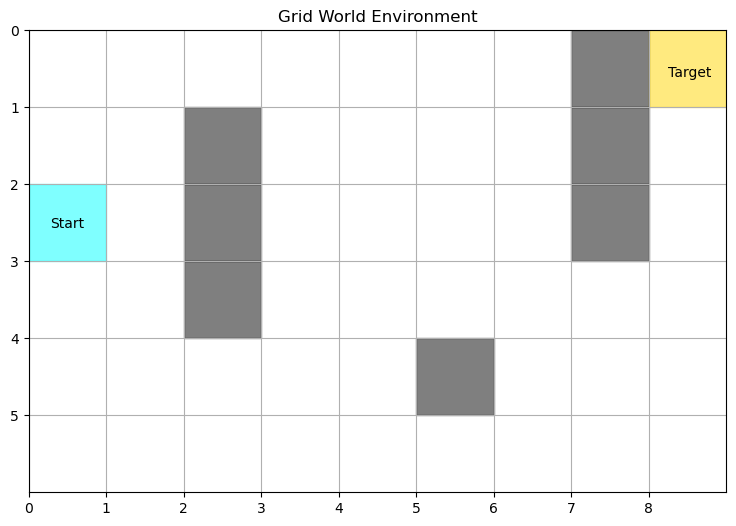

In [ ]:
obs_loc = [(1,2), (2,2), (3,2),
           (4,5),
           (0,7), (1,7), (2,7)]
reward_loc = (0,8)
initial_loc = (2,0)
env = environments.Grid_World_Env(dimensions=(6, 9),
                                  N_obstacles=len(obs_loc), obstacle_locations=obs_loc,
                                  reward_location=reward_loc, state=None)

# Plot the environment
plot_Grid_World(obs_loc, reward_loc, initial_loc)

The glow mechanism marks the transitions a PS agent has deliberated over in the recent past. When a reward is received from the environment, the reinforcement of the marked edges is proportional to how strongly they are still "glowing'' in the memory of the agent. 

The damping parameter (`glow` in the code below, or $\eta$ above) determines how fast the glow of edges decays. Consequently, it allows agents to reinforce a controlled number of edges even though only one transition actually received a reward.

Let us explore the influence of glow in the Grid World environment above by training agents with two-layer ECMs but with different glow parameters.

In [ ]:
N_agents = 100
N_episodes = 50
N_steps_history = []
g_damp_params = np.array([0, 0.04, 0.08, 0.12, 0.15, 0.20, 1.])
N_rewards = []
agents_opt = []

N_steps_history = np.zeros((len(g_damp_params), N_agents, N_episodes))
for d in range(len(g_damp_params)):
    print(f"Glow parameter: {g_damp_params[d]}")
    agents_opt.append([])
    N_rewards.append(0)
    for i in range(N_agents):
        agent = agents.Basic_2Layer_Agent(
            num_actions=4,
            glow=g_damp_params[d],
            damp=0,
            policy='softmax',
            policy_parameters=1,  # Higher beta for sharper policy
            glow_method='init')   # Use 'init' for trajectory credit assignment
        
        for episode in range(N_episodes):
            n_step = 0
            env.reset_position(initial_state=initial_loc)
            percept = env.get_observation()
            reward = 0
            while reward == 0:
                action = agent.deliberate(percept)
                env.transition(action, periodic=False)
                percept = env.get_observation()
                reward = 1 * env.get_reward()
                agent.update(reward)
                if n_step >= 200:  # Prevent infinite loops
                    break
                n_step += 1

            N_rewards[d] += reward
            N_steps_history[d,i,episode] = n_step
            if episode < N_episodes - 1:
                agent.ECM.gmatrix = np.zeros_like(agent.ECM.gmatrix)
        
        agents_opt[d].append(agent)


Glow parameter: 0.0
Glow parameter: 0.04
Glow parameter: 0.08
Glow parameter: 0.12
Glow parameter: 0.15
Glow parameter: 0.2
Glow parameter: 1.0


Let us plot the learning curve and trained model to understand how glow affects learning in the grid world environment.

In [ ]:
def plot_learning_curves(N_steps_history, N_episodes, g_damp_params):
    # Plot the average number of steps to reach the goal
    fig, ax = plt.subplots(figsize=(10, 6))
    colors= ['blue', 'orange', 'green', 'red', 'purple', 'cyan' , 'brown']
    mean_steps = [np.mean(N_steps_history[d,:,:], axis=0) for d in range(len(g_damp_params))]
    std_steps = [np.std(np.array(N_steps_history[d]), axis=0) for d in range(len(g_damp_params))]
    for d in range(len(g_damp_params)):
        ax.plot(list(range(N_episodes)), mean_steps[d],
                label=f'glow={g_damp_params[d]:.2f}', color=colors[d])
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Average Number of Steps to Reach the Goal')
    ax.set_title('Effect of the glow parameter on the number of steps to reach the goal')
    plt.show()

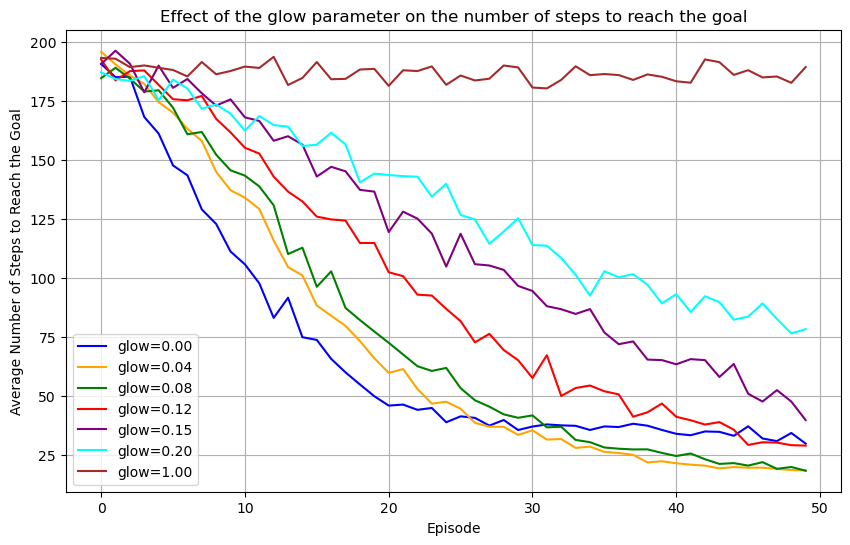

In [ ]:
plot_learning_curves(N_steps_history, N_episodes, g_damp_params)

Glow in this scenario is essential for agents to learn (see the brown curve). For the agents to learn as efficiently as possible, the value for the damping parameter should be tuned carefully, according to the size of the environment, and how many steps are relevant to the reward that is received. 

In particular in this environment, a damping parameter between 0.04 and 0.08 seems to work best. In what follows, we plot glow matrix of an agent on the grid to give intuition about its contribution to learning. Glowing edges between locations on the grid (percepts in the ECM) and directions (actions) are represented by arrows on the grid. At each location that was visited, the size of the arrow is proportional to its glow value.

In [ ]:
from matplotlib.patches import FancyArrow
from projective_simulation.methods.transforms import _softmax

# Plot the grid with obstacles, reward, initial location, and learnt policy arrows
def plot_glow_GW(agents_opt, agent_idx, glow_damping, glow_idx, env, obs_loc, reward_loc, initial_loc):
    # Get grid dimensions
    grid_shape = env.dimensions
    action_colors = ['blue', 'orange', 'green', 'red']  # Colors for the arrows0
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.set_xlim(0, grid_shape[1])
    ax.set_ylim(0, grid_shape[0])
    ax.set_xticks(np.arange(grid_shape[1]))
    ax.set_yticks(np.arange(grid_shape[0]))
    
    # Draw obstacles
    for loc in obs_loc:
        ax.add_patch(plt.Rectangle((loc[1], loc[0]), 1, 1, color='black', alpha=0.5))
    
    # Draw reward location
    ax.add_patch(plt.Rectangle((reward_loc[1], reward_loc[0]), 1, 1, color='gold', alpha=0.5))
    ax.text(reward_loc[1]+0.25, reward_loc[0]+0.6, 'Target')
    
    # Draw initial location
    ax.add_patch(plt.Rectangle((initial_loc[1], initial_loc[0]), 1, 1, color='cyan', alpha=0.5))
    ax.text(initial_loc[1]+0.5, initial_loc[0]+0.85, 'Start', ha='center', va='bottom', color='black')
    
    # Arrow directions: ↑, →, ↓, ←
    arrow_deltas = [(0.35, 0), (-0.35, 0), (0, -0.35), (0, 0.35)]
    
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            cell = (i,j)
            # Skip obstacles and reward
            if cell in obs_loc or cell == reward_loc:
                continue
            percept = str(cell)
            if percept in agents_opt[glow_idx][agent_idx].ECM.percepts:
                glow_values = agents_opt[glow_idx][agent_idx].ECM.gmatrix[agents_opt[glow_idx][agent_idx].ECM.percepts[percept],:]
                for a, glow in enumerate(glow_values):
                    if glow > 0.05:  # Only draw arrows for significant probabilities
                        dx, dy = arrow_deltas[a]
                        ax.add_patch(FancyArrow(j+0.5, i+0.5, dx*glow, dy*glow, width=0.05*glow, length_includes_head=True,
                                               color = action_colors[a], alpha = 0.85))
            else:
                ax.text(j+0.5, i+0.5, '.', ha='center', va='center', color='grey', fontsize=12)
    
    ax.set_title("Grid World Environment")
    ax.set_xticklabels(np.arange(grid_shape[1]))
    ax.set_yticklabels(np.arange(grid_shape[0]))
    ax.invert_yaxis()
    plt.grid(True)
    plt.title(f"Example of the distribution of glow values (damping = {glow_damping})")
    #plt.gca().invert_yaxis()
    plt.show()

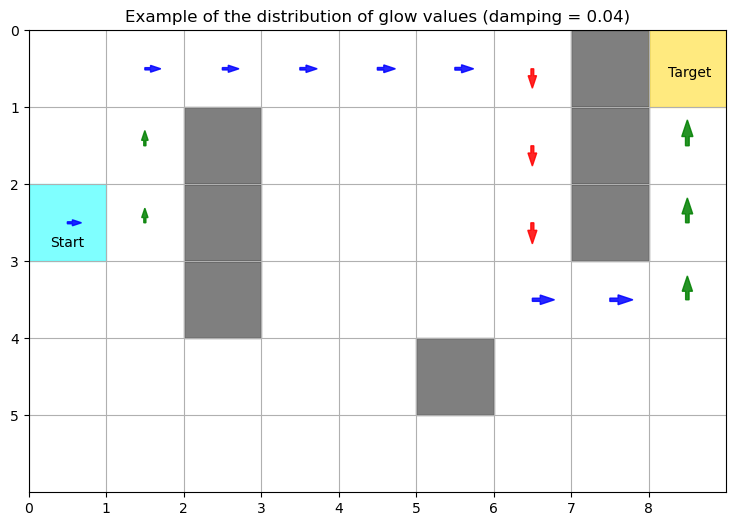

In [ ]:
plot_glow_GW(agents_opt, 0, g_damp_params[1], 1, env, obs_loc, reward_loc, initial_loc)

With the right damping parameter (here 0.04 works), glow allows the agent to reinforce sequences of actions that are just long enough to reach the target. If the damping is too strong (for example 0.20), as shown below, the agent struggles to learn the right actions at the beginning of the sequence because the corresponding edges are associated with negligible values of glow by the end of the sequence. Conversly, if damping is not strong enough (0 being an extreme case), the action sequence that is rewarded incorporates actions that did not contribute to reaching the target.

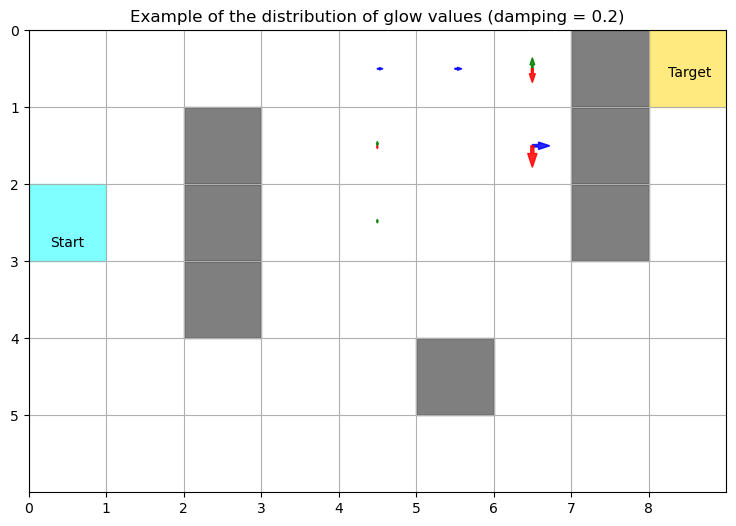

In [ ]:
plot_glow_GW(agents_opt, 0, g_damp_params[-2], -2, env, obs_loc, reward_loc, initial_loc)

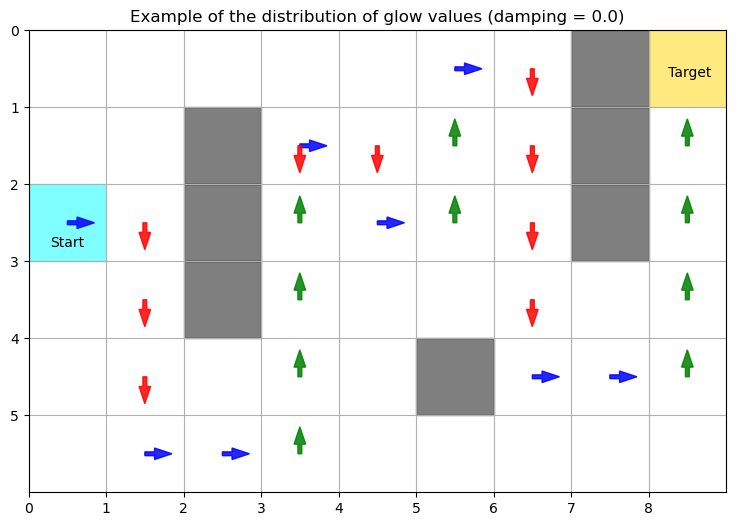

In [ ]:
plot_glow_GW(agents_opt, 20, g_damp_params[0], 0, env, obs_loc, reward_loc, initial_loc)

Finally, we show the final policy of a trained agent on the grid, where the length of each arrows is proportional to the probability of sampling the corresponding action in the final policy of the agent.

In [ ]:
def plot_policy_GW(agents_opt, agent_idx, glow_damping, glow_idx, env, obs_loc, reward_loc, initial_loc):
    # Get grid dimensions
    grid_shape = env.dimensions
    action_colors = ['blue', 'orange', 'green', 'red']  # Colors for the arrows
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.set_xlim(0, grid_shape[1])
    ax.set_ylim(0, grid_shape[0])
    ax.set_xticks(np.arange(grid_shape[1]))
    ax.set_yticks(np.arange(grid_shape[0]))
    
    # Draw obstacles
    for loc in obs_loc:
        ax.add_patch(plt.Rectangle((loc[1], loc[0]), 1, 1, color='black', alpha=0.5))
    
    # Draw reward location
    ax.add_patch(plt.Rectangle((reward_loc[1], reward_loc[0]), 1, 1, color='gold', alpha=0.5))
    ax.text(reward_loc[1]+0.25, reward_loc[0]+0.6, 'Target')
    
    # Draw initial location
    ax.add_patch(plt.Rectangle((initial_loc[1], initial_loc[0]), 1, 1, color='cyan', alpha=0.5))
    ax.text(initial_loc[1]+0.5, initial_loc[0]+0.85, 'Start', ha='center', va='bottom', color='black')
    
    # Arrow directions: ↑, →, ↓, ←
    arrow_deltas = [(0.35, 0), (-0.35, 0), (0, -0.35), (0, 0.35)]
    
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            cell = (i,j)
            # Skip obstacles and reward
            if cell in obs_loc or cell == reward_loc:
                continue
            percept = str(cell)
            if percept in agents_opt[glow_idx][agent_idx].ECM.percepts:
                h = agents_opt[glow_idx][agent_idx].ECM.hmatrix[agents_opt[glow_idx][agent_idx].ECM.percepts[percept],:]
                probs = _softmax(beta=1, x=h)
                for a, prob in enumerate(probs):
                    if prob > 0.05:  # Only draw arrows for significant probabilities
                        dx, dy = arrow_deltas[a]
                        ax.add_patch(FancyArrow(j+0.5, i+0.5, dx*prob, dy*prob, width=0.05*prob, length_includes_head=True,
                                               color = action_colors[a], alpha = 0.85))
            else:
                ax.text(j+0.5, i+0.5, '.', ha='center', va='center', color='grey', fontsize=12)
    
    ax.set_title("Grid World Environment")
    ax.set_xticklabels(np.arange(grid_shape[1]))
    ax.set_yticklabels(np.arange(grid_shape[0]))
    ax.invert_yaxis()
    plt.grid(True)
    plt.title("Trained Policy")
    plt.show()

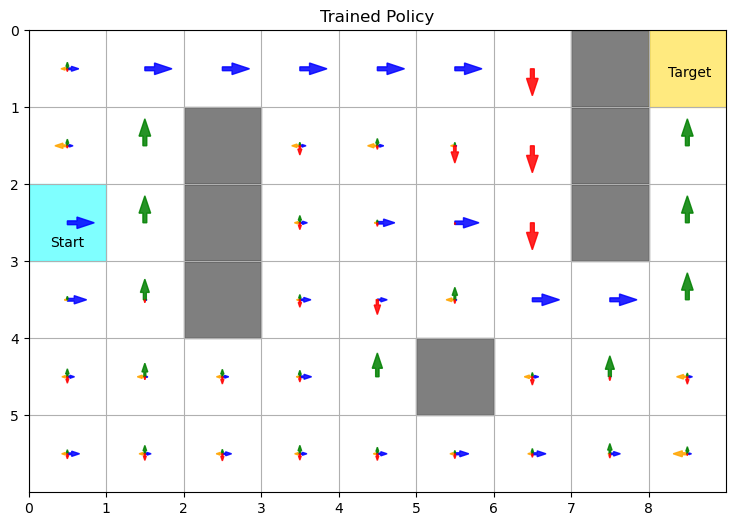

In [ ]:
plot_policy_GW(agents_opt, 0, g_damp_params[1], 1, env, obs_loc, reward_loc, initial_loc)